In [1]:
import numpy as np
import matplotlib.pylab as plt

In [2]:
#----------------------------------------------
#   FUNCTIONS
#----------------------------------------------

def h_operator(nx,obs_vect):
    
    #nx=len(obs_vect)
    index_obs=np.where(obs_vect>-999)[0]
    num_obs=len(index_obs)
    
    h_matrix=np.zeros((num_obs,nx))
    for i in range(num_obs):
        h_matrix[i,index_obs[i]]=1
        
    return h_matrix

In [3]:
def enkf(mem,nx,ensemble,obs_vect,r_obs):
    
    index_obs=np.where(obs_vect>-999)[0]
    num_obs=len(index_obs)

    # Organize the prior vector
    #prior_vect=np.transpose(ensemble)
    prior_vect=ensemble
    
    # Calculate the prior covariance matrix
    mean_prior=np.mean(prior_vect,axis=1)
    cov_prior=np.cov(prior_vect)
    
#     ------------------------
#     Localization
#     ------------------------
#     r_influ=4
#     tmp = np.zeros((nx, nx))
#     for i in range(1, 3*r_influ+1):
#         tmp += np.diag(np.ones(nx-i), i) + np.diag(np.ones(nx-i), -i) + \
#                np.diag(np.ones(i),nx-i) + np.diag(np.ones(i), -(nx-i))
#         tmp *= np.exp(-i**2 / r_influ**2)
#     mask = tmp + np.diag(np.ones(nx))
#     cov_prior=np.multiply(cov_prior,mask)
#     ------------------------

#     # Perturbed observation vector
    obs_vect_filtered=obs_vect[index_obs]

    obs_vect_perturbed=np.zeros((num_obs,mem))
    
    eps_vect=np.zeros((num_obs,mem))
    
    for i in range(mem):
        eps_vect[:,i]=np.random.normal(0,r_obs,len(index_obs))
        obs_vect_perturbed[:,i]=obs_vect_filtered[:,0]+eps_vect[:,i]  
  
    cov_obs=np.identity(num_obs)*r_obs**2
    
    
#     # Calculate the observation operator
    h_matrix=h_operator(nx,obs_vect)  
    
#     # Calculate the kalman gain
    
    k_left=cov_prior.dot(np.transpose(h_matrix))
    
    k_right=h_matrix.dot(cov_prior).dot(np.transpose(h_matrix))+cov_obs
    
    k_right_inv=np.linalg.inv(k_right)

    kalman_gain=k_left.dot(k_right_inv)
    
#     # Calculate the innovation
    
    innovation=obs_vect_perturbed-h_matrix.dot(prior_vect)

    
#     # Calculate the posterior
    
    posterior_vect=prior_vect+kalman_gain.dot(innovation)

    mean_posterior=np.mean(posterior_vect, axis=1)
    
    cov_posterior=np.cov(posterior_vect)
    
    
    enkf={"posterior":posterior_vect,"kalman_gain":kalman_gain,"innovation":innovation,
          "mean_post":mean_posterior,"cov_post":cov_posterior,"post_matrix":posterior_vect}
    
    return enkf

In [4]:
# Version 1

def L96_RK4(X, dt, F):
    # integrate for L96 model using RK4
    # X is the input, dt is the time resolution
    # X_out is the output

    dim = len(X)
    k1 = np.zeros(dim)
    k2 = np.zeros(dim)
    k3 = np.zeros(dim)
    k4 = np.zeros(dim)
    X_out = np.zeros(dim)

    # parameter for the model
    # F = 8;

    tmp_b = X.copy()  # before integration
    
    X_p1 = np.concatenate((tmp_b[1:], [tmp_b[0]]))
    X_00 = tmp_b
    X_n1 = np.concatenate(([tmp_b[-1]], tmp_b[:-1]))
    X_n2 = np.concatenate((tmp_b[-2:], tmp_b[:-2]))
    
    k1 = (X_p1 - X_n2) * X_n1 - X_00 + F
    
    tmp_b = X + 0.5 * k1 * dt
    X_p1 = np.concatenate((tmp_b[1:], [tmp_b[0]]))
    X_00 = tmp_b
    X_n1 = np.concatenate(([tmp_b[-1]], tmp_b[:-1]))
    X_n2 = np.concatenate((tmp_b[-2:], tmp_b[:-2]))
    
    k2 = (X_p1 - X_n2) * X_n1 - X_00 + F
    
    tmp_b = X + 0.5 * k2 * dt
    X_p1 = np.concatenate((tmp_b[1:], [tmp_b[0]]))
    X_00 = tmp_b
    X_n1 = np.concatenate(([tmp_b[-1]], tmp_b[:-1]))
    X_n2 = np.concatenate((tmp_b[-2:], tmp_b[:-2]))
    
    k3 = (X_p1 - X_n2) * X_n1 - X_00 + F
    
    tmp_b = X + k3 * dt
    X_p1 = np.concatenate((tmp_b[1:], [tmp_b[0]]))
    X_00 = tmp_b
    X_n1 = np.concatenate(([tmp_b[-1]], tmp_b[:-1]))
    X_n2 = np.concatenate((tmp_b[-2:], tmp_b[:-2]))
    
    k4 = (X_p1 - X_n2) * X_n1 - X_00 + F
    
    X_out = X + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    return X_out


In [5]:
def calc_X(X):
    # Calculate X_p1, X_00, X_n1, and X_n2
    X_p1 = np.roll(X, -1, axis=0)
    X_00 = X.copy()
    X_n1 = np.roll(X, 1, axis=0)
    X_n2 = np.roll(X, 2, axis=0)
    return X_p1, X_00, X_n1, X_n2

def L96_RK4_ensemble(X_in, dt, F):
    """
    Integrate the Lorenz 96 model using RK4 for an ensemble of n_mem members
    
    Parameters:
    -----------
    X_in: numpy.ndarray
        Input array of shape (dim, n_mem)
    dt: float
        Time resolution
    F: float
        Parameter for the model
    
    Returns:
    --------
    X_out: numpy.ndarray
        Array of shape (dim, n_mem) containing the output of the integration
    """
    dim, n_mem = X_in.shape
    k1 = np.zeros((dim, n_mem))
    k2 = np.zeros((dim, n_mem))
    k3 = np.zeros((dim, n_mem))
    k4 = np.zeros((dim, n_mem))
    X_out = np.zeros((dim, n_mem))

    tmp_b = X_in.copy()  # before integration
    
    X_p1, X_00, X_n1, X_n2 = calc_X(tmp_b)

    # Calculate k1
    k1 = (X_p1 - X_n2) * X_n1 - X_00 + F

    tmp_b2 = X_in + 0.5 * k1 * dt
    X_p1, X_00, X_n1, X_n2 = calc_X(tmp_b2)

    # Calculate k2
    k2 = (X_p1 - X_n2) * X_n1 - X_00 + F

    tmp_b3 = X_in + 0.5 * k2 * dt
    X_p1, X_00, X_n1, X_n2 = calc_X(tmp_b3)

    # Calculate k3
    k3 = (X_p1 - X_n2) * X_n1 - X_00 + F

    tmp_b4 = X_in + k3 * dt
    X_p1, X_00, X_n1, X_n2 = calc_X(tmp_b4)

    # Calculate k4
    k4 = (X_p1 - X_n2) * X_n1 - X_00 + F

    X_out = X_in + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    return X_out


In [6]:
# Test for Lorenz 96 Ensemble Forward Model 2023/03/10
# by Hamed Ali Diab-Montero
# h.a.diabmontero@tudelft.nl\

# TRUTH
F = 1.2
n_x = 10                       # size of the state vector
X_in = F*np.ones((n_x,1))      # initial condition (for steady state)
#X_in[0,0] += 0.01  # Add small perturbation to the first variable

#X_in[n_x//5:n_x:n_x//5] = F+1  # perturbed IC (to generate chaotic behavior)
X_in[n_x//2:n_x:n_x//2] = F+1  # perturbed IC (to generate chaotic behavior)

# Time information
warm_nt = 1000                 # number of warm-up time steps
n_t = 5000                     # number of time steps to simulate
tstep = 0.01                   # time step size

t_truth = np.zeros(warm_nt + n_t)
t_truth[0] = tstep
for t in range(warm_nt + n_t - 1):
    t_truth[t+1] = t_truth[t] + tstep

X_truth = np.zeros((n_x, warm_nt + n_t))
X_truth[:,0] = X_in[:,0]
for t in range(warm_nt + n_t - 1):
    X_truth[:,t+1] = L96_RK4(X_truth[:,t], tstep, F)

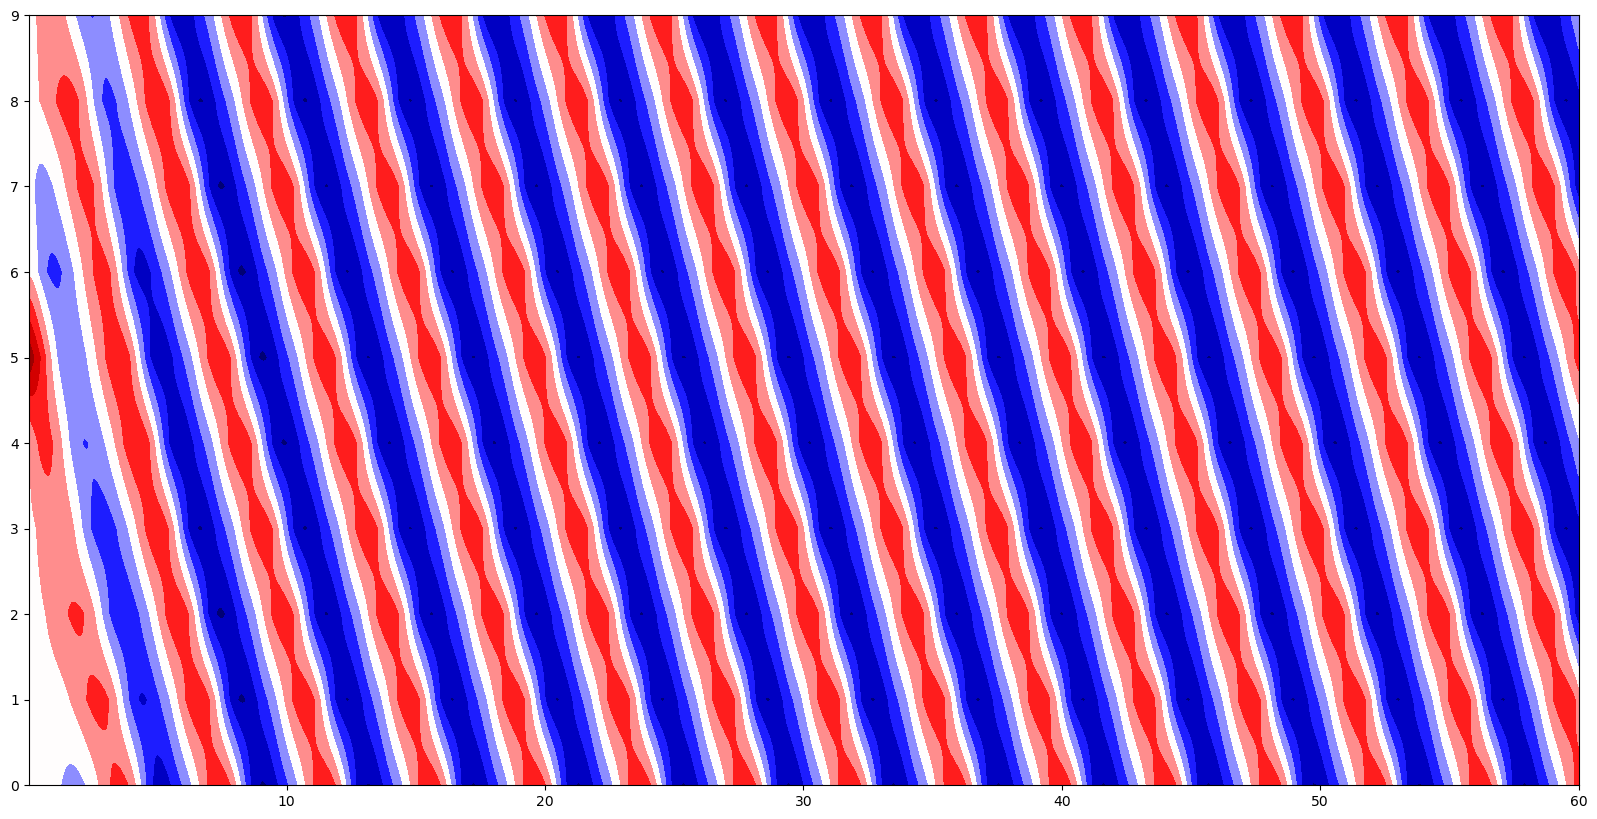

In [7]:
X_truth.shape
fig=plt.figure(figsize=(20,10))
x=t_truth
y=range(n_x)
X,Y = np.meshgrid(x,y)
t_cutoff=6000
#lt.pcolor(X[:,0:2000],Y[:,0:2000],X_truth[:,0:2000],cmap='seismic')
plt.contourf(X[:,0:t_cutoff],Y[:,0:t_cutoff],X_truth[:,0:t_cutoff],cmap='seismic')

In [8]:
#OBSERVATIONS
obs_rate = 50      # interval of time steps between observations
obs_den = 1        # observation density (every obs_den -th grids are observed)
t_obs = t_truth[::obs_rate]
index_truth = range(len(t_truth))

mu_pert = 0
sigma_pert = 1.5

# Dataset to test method
# x_dataset = np.loadtxt('obs_l96_40_100000.txt')

# Observations
r_eps = np.sqrt(2)
mu_pert = 0
pert_obs = np.random.normal(mu_pert, r_eps, [ len(t_obs), int(n_x/obs_den)])

#n_obs = 2
# NOTE: @Hamed -->modify from here
x_obset = np.ones((len(t_obs), n_x+2)) * -999
x_obset[:, 0] = t_obs
x_obset[:,1] = index_truth[::obs_rate]
x_obset[:, 2::obs_den] = np.transpose(X_truth[::obs_den,::obs_rate]) + pert_obs

# t_first_da = 10
# n_obs = np.count_nonzero(x_obset[t_first_da, 1:] > -999)

# r_eps = 0.3

In [9]:
X_truth.shape

(10, 6000)

In [10]:
t_truth[-1]

59.99999999999663

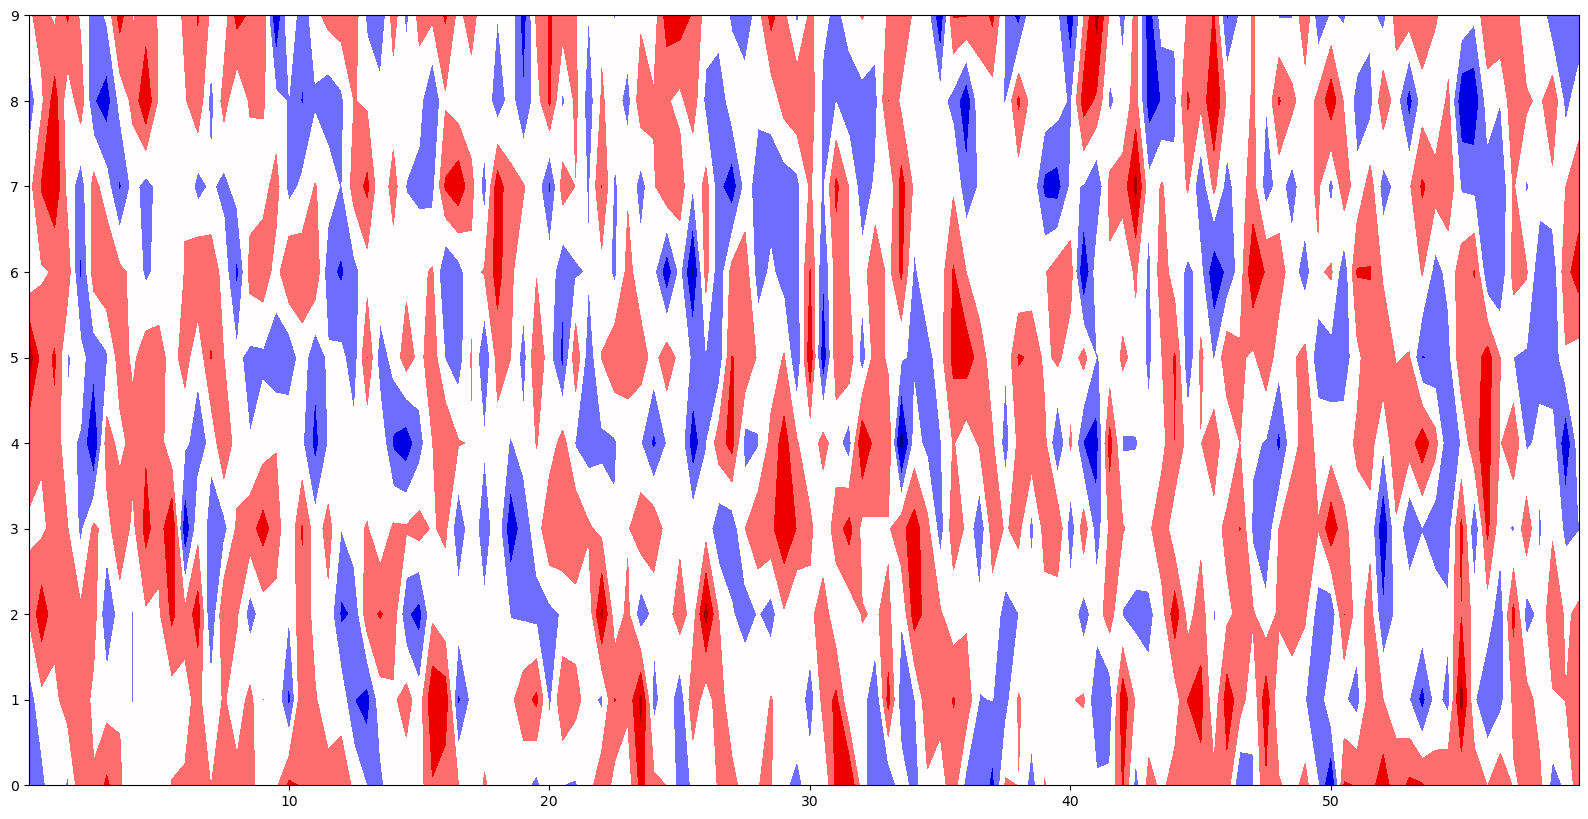

In [11]:
fig=plt.figure(figsize=(20,10))
x=t_obs
y=range(n_x)
X,Y = np.meshgrid(x,y)
#plt.pcolor(X,Y,np.transpose(x_obset[:,2:]),cmap='seismic')
plt.contourf(X,Y,np.transpose(x_obset[:,2:]),cmap='seismic')

In [12]:
#-----------------------------------------
# Ensemble Kalman FIlter
#-----------------------------------------

n_mem=100;                  # N - Ensemble size
                            # Bandwith hyperparameter5

ctlmean = X_truth[:, 0] + np.random.multivariate_normal(np.zeros(n_x), np.eye(n_x)).T

# initial condition
n_t=len(t_truth)
X_t = np.zeros((n_x, n_mem, n_t))
Q = 2 * np.eye(n_x)            # background error covariance (only for the initial perturbation)
Q_inv = np.linalg.inv(Q)
X_t[:,:,0] = np.random.multivariate_normal(ctlmean, Q, n_mem).T

X_0 = np.loadtxt('prior_l96_40_100_particles.txt')
# X_t[:,:,0] = X_0.copy()

t_first_da = int(warm_nt/obs_rate)+1 # index first assimilation 
n_obs = np.sum(x_obset[t_first_da, 2:] > -999)

t = warm_nt+1
# We will assimilate this number of steps
# t_assim < len(t_truth)-obsrate 
t_assim = len(t_truth)-50

for k in range(warm_nt):
    X_t[:,:,k+1] = L96_RK4_ensemble(X_t[:,:,k], tstep, F)

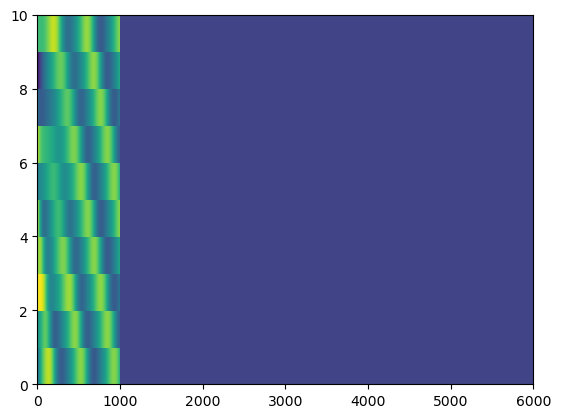

In [13]:
plt.pcolor(X_t[:,0,:])

In [14]:
warm_nt

1000

In [15]:
# Test forward modelling ensemble
# n_t=4000
# for t in range(warm_nt + n_t - 1):
#     X_t[:,:,t+1] = L96_RK4_ensemble(X_t[:,:,t], tstep, F)
# plt.pcolor(X_t[:,0,:])

In [16]:
t_first_da

21

In [17]:
int(np.ceil(t_obs[t_first_da]/tstep))

1051

In [18]:
d = t_first_da

# K_gain_t = np.zeros((n_x, n_x, len(t_obs)))

# n_t=len(t_truth)-warm_nt-1

while t*tstep < t_assim*tstep:
    
    t_analysis = int(np.ceil(t_obs[d]/tstep))
  
    # I need to start in k-1 beacause of the index system of python
    # We need to stop in t_analysis because of the index system of python
    for k in range(t, t_analysis,1):
        X_t[:,:,k] = L96_RK4_ensemble(X_t[:,:,k-1], tstep, F)
   
    t = t_analysis

    # Observations
    y_t = np.zeros((n_obs, 1))
    index_obs = np.where(x_obset[d, 2:] > -999)[0] # Experiment specific
    #y_t[:, 0] = x_obset[d, 2:] # Experiment specific
    y_t[:, 0] = x_obset[d, 2:][index_obs] # Experiment specific

    # Ensemble Kalman Filter part of the method
    # We need to access t-1 because of the inx system of python
    post_enkf = enkf(n_mem, n_x, X_t[:, :, t-1], y_t, r_eps)

    X_ens_mean=post_enkf['mean_post']
    X_ens=post_enkf['post_matrix']
    P_ens=post_enkf['cov_post']
#     K_gain_t[:, :, d]=post_enkf['kalman_gain']
     # We need to access t-1 because of the inx system of python
    X_t[:, :, t-1] = X_ens.copy()
    P_t = P_ens   
    
    d += 1
    
print('Finished with the estimation')

Finished with the estimation


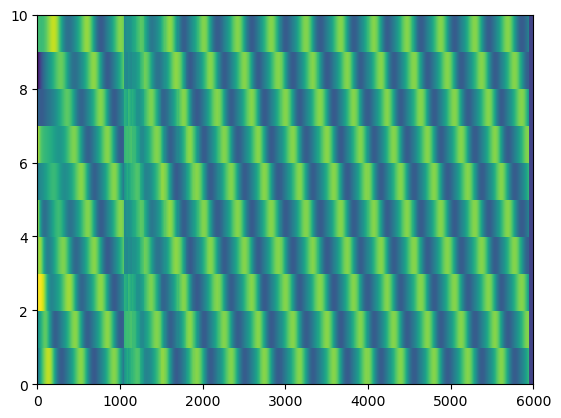

In [19]:
plt.pcolor(X_t[:,0,:])

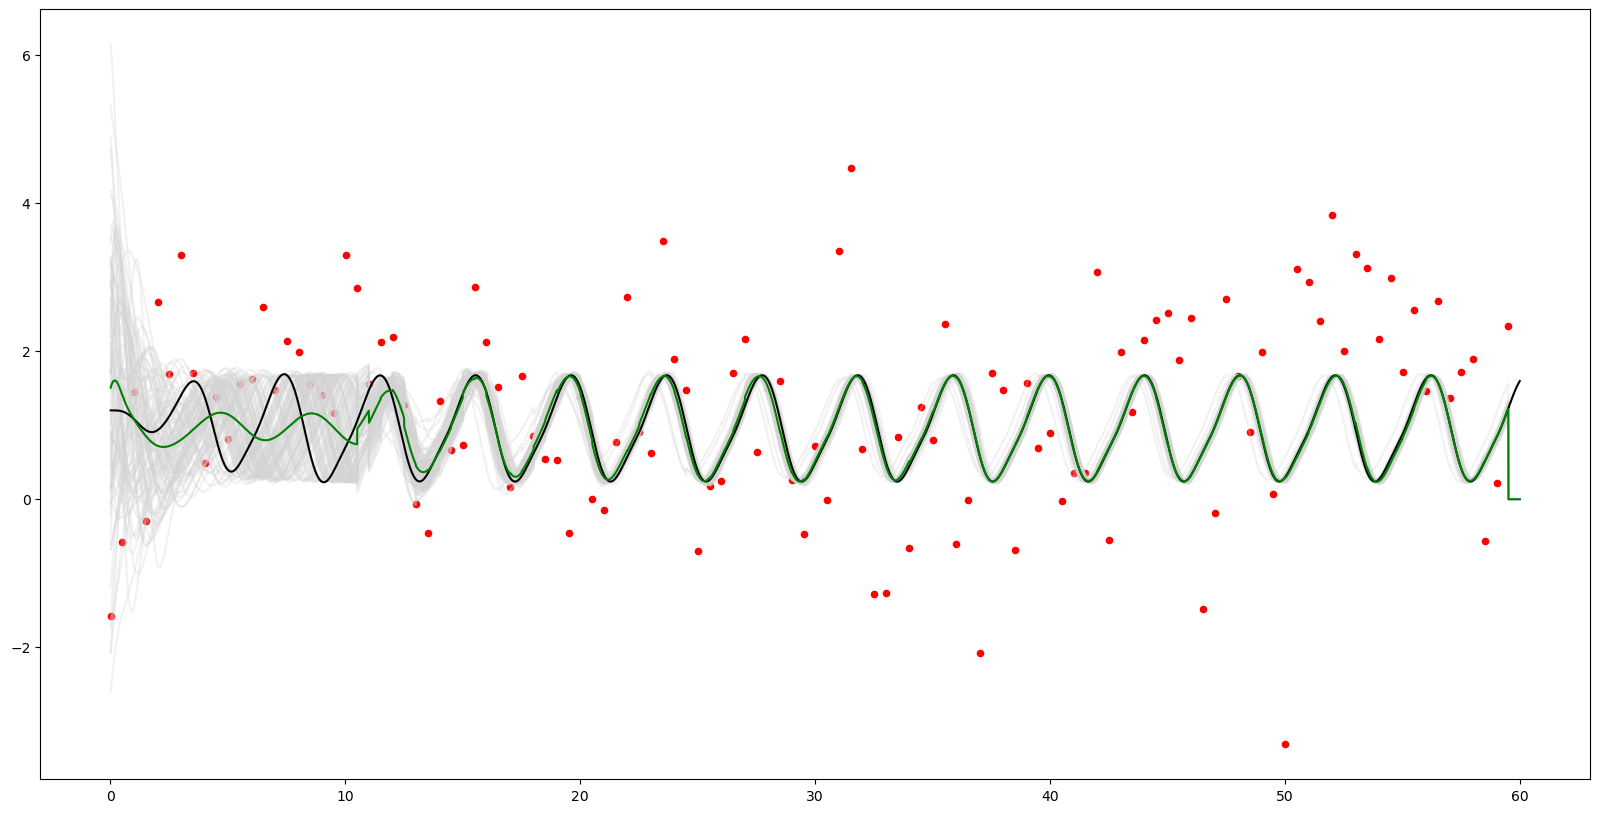

In [20]:
index_variable=0
fig=plt.figure(figsize=(20,10))
for i in range(n_mem):
    plt.plot(t_truth,X_t[index_variable,i,:],color='lightgray',alpha=0.3)
plt.plot(t_truth,X_truth[index_variable,:],color='k')
plt.plot(t_truth,np.mean(X_t[index_variable,:,:],axis=0),color='g')
plt.scatter(t_obs,x_obset[:,index_variable+2],color='r',s=20)
# plt.xlim(0,1000)

# RMSE

In [21]:
#
#  RMSE CALCULATION
#

X_t_mean=np.mean(X_t,axis=1)
print(X_t_mean.shape)

error_x_t=np.zeros((n_x,len(t_truth)))
for i in range(n_x):
    error_x_t[i,:]=(X_t_mean[i,:]-X_truth[i,:])**2
    
rmse_x_t=np.sqrt((1/n_x)*np.sum(error_x_t,axis=0))

(10, 6000)


Text(0, 0.5, 'RMSE')

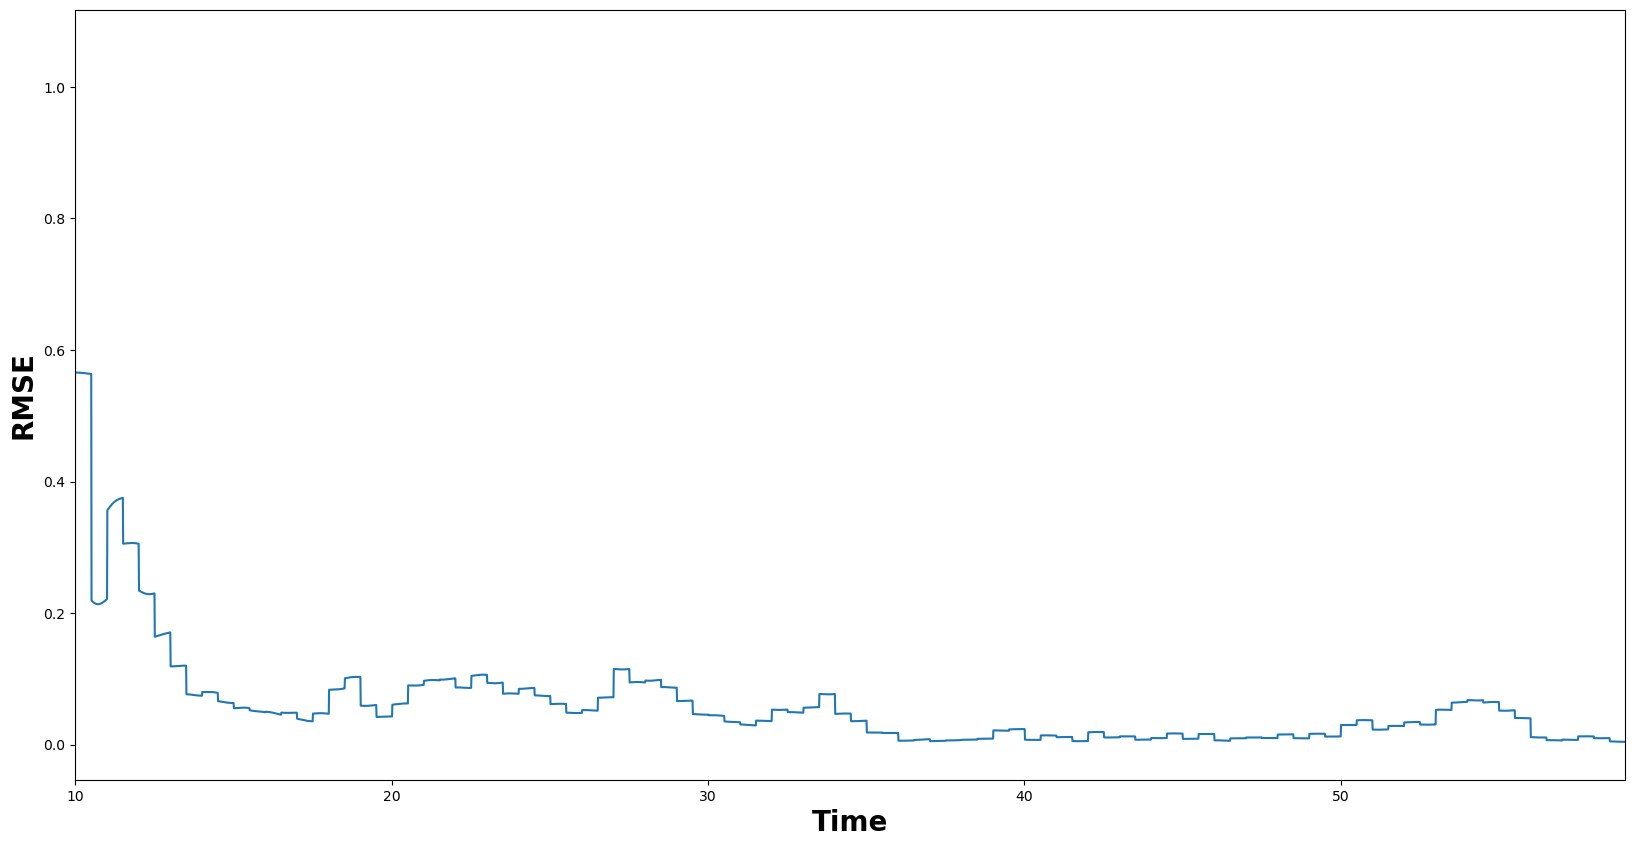

In [22]:
fig=plt.figure(figsize=(20,10))
plt.plot(t_truth,rmse_x_t)
plt.vlines(x=10,ymin=0,ymax=1,label='start data assimilation',color='r')
plt.xlim(10,59)
plt.xlabel('Time',fontsize=20,fontweight='bold')
plt.ylabel('RMSE',fontsize=20,fontweight='bold')

In [23]:
# SAVE FILES
n_run_exp='10'

filename='./results_rmse/rmse_l96_periodic_obs_err_04_run_'+n_run_exp+'.txt'
results_rmse=np.zeros((len(t_truth),2))
results_rmse[:,0]=t_truth[:]
results_rmse[:,1]=rmse_x_t[:]

np.savetxt(filename,results_rmse)

# Covariance matrix analysis

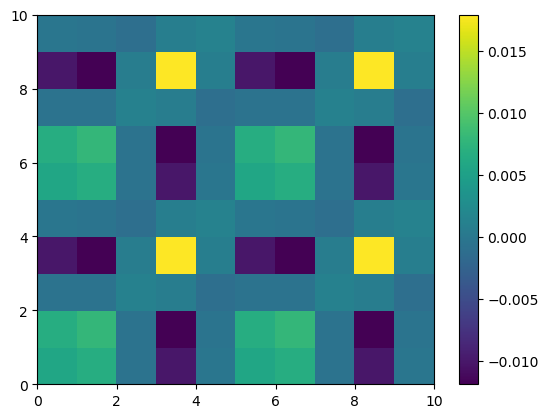

In [24]:
B_analysis=np.cov(X_t[:,:,3000])
plt.pcolor(B_analysis)
plt.colorbar()

In [25]:
r_influ=4
tmp = np.zeros((n_x, n_x))
for i in range(1, 3*r_influ+1):
    tmp += np.diag(np.ones(n_x-i), i) + np.diag(np.ones(n_x-i), -i) + \
           np.diag(np.ones(i),n_x-i) + np.diag(np.ones(i), -(n_x-i))
    tmp *= np.exp(-i**2 / r_influ**2)
mask = tmp + np.diag(np.ones(n_x))
plt.pcolor(mask)
plt.colorbar()
B_analysis_loc=np.multiply(B_analysis,mask)
plt.pcolor(B_analysis_loc)

ValueError: negative dimensions are not allowed